# Writing rotated model grids to rasters
so they can be viewed in a GIS

In this example, we want to make a raster of heads output for a MODFLOW model that is rotated 20 degrees clockwise

In [1]:
import sys
sys.path.append('D:/ATLData/Documents/GitHub/flopy/')
sys.path.append('/Users/aleaf/Documents/GitHub/flopy3/')
import numpy as np
import rasterio
from rasterio import Affine
from scipy.ndimage import rotate
import flopy
from flopy.utils.reference import SpatialReference
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
hdsfile = '4-Output/A-calibration/clas.hds'
model_ws = '3-Input/A-calibration'
fm = flopy.modflow

xll, yll = -244389.35, 248497.84
epsg = 5070 # apparently not on spatialreference.org
rot = 20.
dxdy = 5280
dxdy_m = 5280*.3048

### Read in some head results; make a flopy spatial reference object 
get the results from stress period 1, timestep 1

In [3]:
hdsobj = bf.HeadFile(hdsfile)
hds = hdsobj.get_data(kstpkper=(0, 0))
nlay, nrow, ncol = hds.shape

sr = SpatialReference(delc=np.ones(nrow, dtype=float)*dxdy, 
                      delr=np.ones(ncol, dtype=float)*dxdy, 
                      xll=xll, yll=yll, rotation=rot,
                      length_multiplier=0.3048)

#m = fm.Modflow.load('clas.nam', model_ws=model_ws)

/Users/aleaf/Documents/GitHub/flopy3/flopy/utils/reference.py:605: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)
/Users/aleaf/Documents/GitHub/flopy3/flopy/utils/reference.py:465: UserWarning: rotation arg has recently changed. It was previously treated as positive clockwise. It now is positive counterclockwise.
  warnings.warn(msg)


### unfortunately the `IPHDRY` option was used, so cells above the water table have values of -9999

In [4]:
hds[0]

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ..., 
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]], dtype=float32)

### iterate through the grid to get a 2D array of the water table surface

In [5]:
nodata = -9999.
wt = []
for i in range(nrow):
    for j in range(ncol):
        for k in range(nlay):
            if hds[k, i, j] != nodata:
                wt.append(hds[k, i, j])
                break
            elif k == nlay-1:
                wt.append(nodata)
assert len(wt) == nrow * ncol
wt = np.reshape(wt, (nrow, ncol))

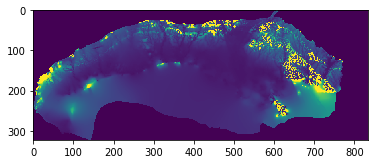

In [6]:
plt.imshow(wt, vmin=-30, vmax=500)

### Rotate the heads array using `scipy.ndimage.rotate`
set all nodata values to np.nan

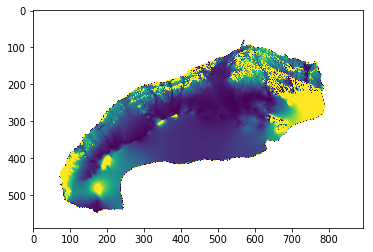

In [7]:
rotated = rotate(wt, sr.rotation, cval=nodata)
rotated[rotated < -1e3] = np.nan
plt.imshow(rotated, vmin=0, vmax=200)

### Compute a transform for the rotated array, using its shape and bounds from `SpatialReference`

In [8]:
height_rot, width_rot = rotated.shape
xmin, ymin, xmax, ymax = sr.bounds
dx = (xmax-xmin)/width_rot
dy = (ymax-ymin)/height_rot
trans = Affine(dx, 0, xmin, 0, -dy, ymax)

### Write a GeoTiff using `rasterio`
Note: we could also write an arc ascii grid at this point

In [9]:
meta = {'driver': 'GTiff',
        'width': width_rot,
        'height': height_rot,
        'transform': trans,
        'crs': 'EPSG:5070',
        'count': 1,
        'dtype': np.float64,
        'nodata': -9999.}

with rasterio.open('postproc/wt2.tif', 'w', **meta) as dst:
    dst.write(rotated, 1)